## Extract and Remove Value/Unit from catalog_content
This cell extracts the Value and Unit from the end of `catalog_content`, creates two new columns, and then strips these details from the original text.

# Import Libraries and Create Directories

In [230]:
# Install PyTorch if not already installed
# paste this in terminal:
# pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu126
# !pip install scikit-learn
# !pip install pandas numpy matplotlib jupyterlab ipywidgets
# !pip install xgboost

In [184]:
import os
import pandas as pd
import numpy as np
from IPython import display
from urllib.parse import urlparse, unquote
import re
import torch
from pathlib import Path
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', None)

In [185]:
# projects_dir_path = os.path.join(os.getcwd(), "projects")
# # os.makedirs(projects_dir_path, exist_ok=True)
# price_predict_project_path = os.path.join(projects_dir_path, "price_predict")
# os.makedirs(price_predict_project_path, exist_ok=True)
# os.chdir(price_predict_project_path)

move the csv files into the 'dataset' directory after creating it

In [186]:
# put your own directory path where the dataset is located
os.chdir(r'C:\Users\alvin\Desktop\projects\price_predict\dataset')

In [187]:
# check if the directories are created successfully
os.listdir()

['images', 'sample_test.csv', 'sample_test_out.csv', 'test.csv', 'train.csv']

In [189]:
# load the training data
train_df = pd.read_csv("train.csv")
train_df.sample(1)

,sample_id,catalog_content,image_link,price
49080,140365,"Item Name: Gangotri GangaJal 330ml\nBullet Point 1: Remedy Of Many Diseases\nBullet Point 2: Good For Health\nBullet Point 3: good for health\nProduct Description: Gangajal is collected from Gangotri, Uttrakhand. This holy water is made available in its purest and existing form. Gangotri Gangajal is kept untouched from human hands. Gangajal is not treated artificially/chemically in the whole procedure, so that its sacredness is not spoiled. The holy Gangotri Ganga Pure Gangajal water originates from gomukh and flowing through the mountains of Gangotri and Riskesh (Uttranchal) bring with in the goodness of herbs and medicinal plant to Hardwar and beyond. As such, drinking this water cures many diseases.\nValue: 11.16\nUnit: Fl Oz\n",https://m.media-amazon.com/images/I/41f7XfNem1L.jpg,9.85


# Check data quality

In [190]:
# Check for missing values
train_df.isnull().sum()

sample_id          0
catalog_content    0
image_link         0
price              0
dtype: int64

In [191]:
# Remove 'Item Name: ' prefix from catalog_content
def remove_item_name_prefix(text):
    return text.strip().replace('Item Name:', '').strip()

extracted_df = train_df.copy()
extracted_df['catalog_content'] = extracted_df['catalog_content'].apply(remove_item_name_prefix)
extracted_df.sample(1)

,sample_id,catalog_content,image_link,price
72272,118036,"Oscar Mayer Single Serve Ham Convenience Meal, 3.3 Ounce -- 7 per case.\nValue: 23.1\nUnit: Ounce",https://m.media-amazon.com/images/I/81sX+6eEZ7L.jpg,2.98


Every single record comes with values and units except for one, do a bit of Feature Engineering

In [192]:
# Extract "Value" and "Unit" from catalog_content into two new columns, then remove them from catalog_content
def extract_value_unit_and_strip(text):
    match = re.search(r'Value:\s*([^\n]+)\s*Unit:\s*([^\n]+)', text)
    if match:
        value = match.group(1).strip()
        unit = match.group(2).strip()
        # Remove the matched part from the text
        stripped = re.sub(r'Value:\s*[^\n]+\s*Unit:\s*[^\n]+', '', text).strip()
        return pd.Series([value, unit, stripped])
    else:
        return pd.Series([None, None, text])


extracted_df[['value', 'unit', 'catalog_content']] = extracted_df['catalog_content'].apply(extract_value_unit_and_strip)

In [193]:
extracted_df.sample(1)

,sample_id,catalog_content,image_link,price,value,unit
38908,254660,7 Up Cherry Soda in 12 oz cans (12 Cans)\nBullet Point: 7 Up Cherry Soda in 12 oz cans (12 Cans)\nProduct Description: 7 Up Cherry Soda in 12 oz cans (12 Cans),https://m.media-amazon.com/images/I/41GZFwt8gDL.jpg,13.47,144.0,Fl Oz


In [194]:
# number of records share everything the same except for price
extracted_df[['catalog_content', 'image_link', 'value', 'unit']].duplicated().sum()

np.int64(46)

Some records share the same images, even though they are the same product, they have different quantities

In [195]:
# Get the columns we want to check
cols_to_check = ['catalog_content', 'image_link', 'value', 'unit']
# Create boolean mask of duplicated rows
duplicated_mask = extracted_df[cols_to_check].duplicated(keep=False)
# Filter the dataframe using the mask
dup_df = extracted_df[duplicated_mask].sort_values(by='image_link')
dup_df.sample(1)

,sample_id,catalog_content,image_link,price,value,unit
4468,133980,"McCormick Golden Dipt Cracker Meal Seafood Fry Mix, 10 oz (Pack of 8)\nBullet Point 1: Wheat flour-based fry mix gives seafood a crumb coating that seals in juices\nBullet Point 2: 3 easy steps: lightly moisten fish, coat with Cracker Meal, then fry\nBullet Point 3: Tasty with tilapia, shrimp, scallops, shucked oysters and soft-shell crabs\nBullet Point 4: Substitute Cracker Meal for bread crumbs in meat loaf or meat balls\nBullet Point 5: Dip fish in a mixture of 3 tbsp milk and 2 beaten eggs for a thicker coating",https://m.media-amazon.com/images/I/81aNgo-u-RL.jpg,26.8,80.0,Ounce


In [196]:
extracted_df.shape

(75000, 6)

In [197]:
# Group by catalog_content and image_link, then aggregate
cleaned_df = extracted_df.groupby(cols_to_check).agg({
    'sample_id': 'min',  # keep lowest sample_id
    'price': 'mean'      # take average of prices
}).reset_index()

# Show the first few rows to verify
# cleaned_df.sample(5)

# Print the reduction in records
print(f"Original records: {len(cleaned_df)}")
print(f"After deduplication: {len(cleaned_df)}")

Original records: 74953
After deduplication: 74953


# Download and Handle Images

In [199]:
images = train_df['image_link']
images.sample(5)

5849     https://m.media-amazon.com/images/I/71RQX7YVihL.jpg
19382    https://m.media-amazon.com/images/I/71hffHoVtHL.jpg
4047     https://m.media-amazon.com/images/I/71V9vrIz9OL.jpg
14828    https://m.media-amazon.com/images/I/61l8+I-8c7L.jpg
16597    https://m.media-amazon.com/images/I/21hueQ5oXcL.jpg
Name: image_link, dtype: object

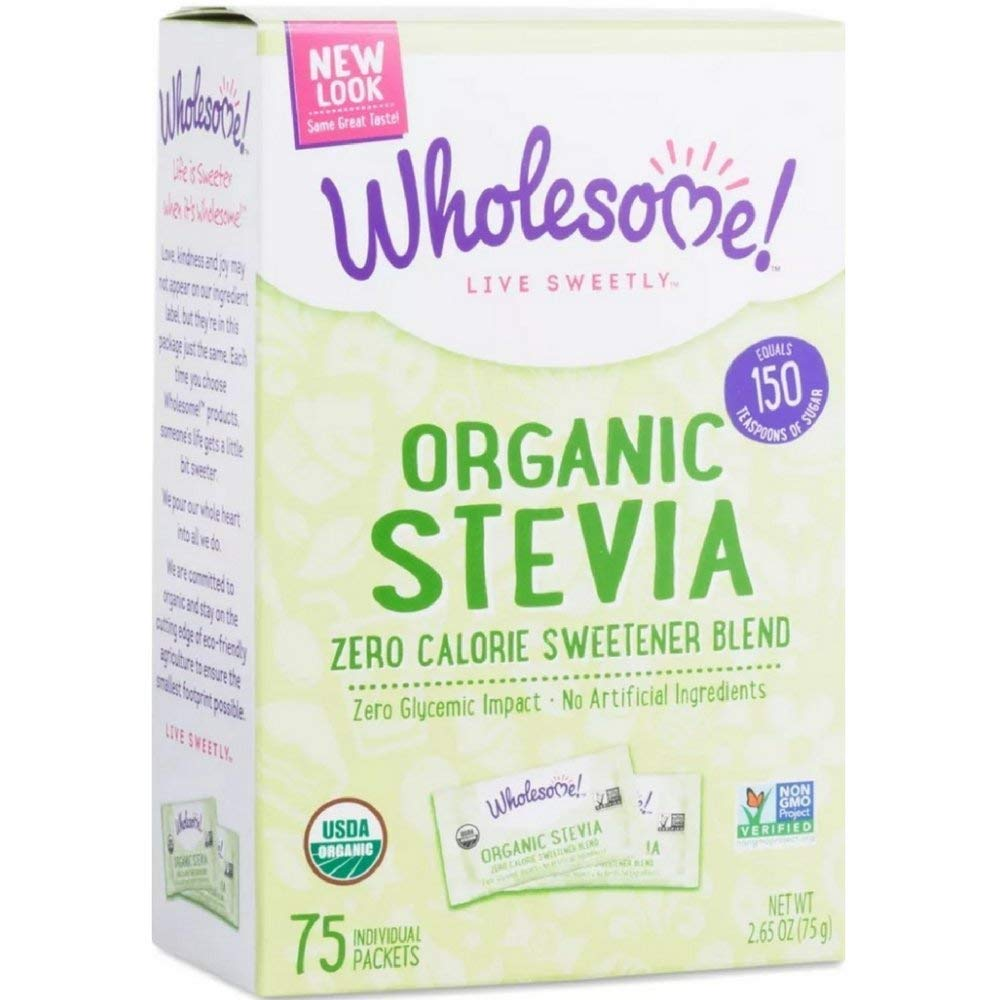

In [200]:
# Get a single image URL
test_image = images.sample(1).iloc[0] # use iloc because sample returns a Series
# test_image = images.sample(1)
display.Image(test_image, width=300, height=200)
# display.Image()

In [201]:
print(test_image)

https://m.media-amazon.com/images/I/61jqxoYuIXL.jpg


## Downloading Images

In [202]:
# # functions provided by Kaggle to download images
# import re
# import os
# import pandas as pd
# import multiprocessing
# from time import time as timer
# from tqdm import tqdm
# import numpy as np
# from pathlib import Path
# from functools import partial
# import requests
# import urllib
# # download single image
# def download_image(image_link, savefolder):
#     if(isinstance(image_link, str)):
#         filename = Path(image_link).name
#         image_save_path = os.path.join(savefolder, filename)
#         if(not os.path.exists(image_save_path)):
#             try:
#                 urllib.request.urlretrieve(image_link, image_save_path)    
#             except Exception as ex:
#                 print('Warning: Not able to download - {}\n{}'.format(image_link, ex))
#         else:
#             return
#     return
# # download multiple images in parallel
# def download_images(image_links, download_folder):
#     if not os.path.exists(download_folder):
#         os.makedirs(download_folder)
#     results = []
#     download_image_partial = partial(download_image, savefolder=download_folder)
#     with multiprocessing.Pool(50) as pool:
#         for result in tqdm(pool.imap(download_image_partial, image_links), total=len(image_links)):
#             results.append(result)
#         pool.close()
#         pool.join()

# Finalize the Dataset

In [203]:
os.listdir()

['images', 'sample_test.csv', 'sample_test_out.csv', 'test.csv', 'train.csv']

In [205]:
# Multi-threading is somehow not working for my machine, downloading images one by one. Try the download_images function first and see if it works
# for image in images:
#     download_image(image, images_dir_path)

In [206]:
# number of images that are unable to be downloaded
len(images) - len(os.listdir("images"))

25604

In [ ]:
# match records with corresponding image paths
IM_DIR = Path("images")
all_paths = [p for p in IM_DIR.rglob("*")]
by_last15_fname = {}
by_last15_stem  = {}

for p in all_paths:
    fname = p.name.lower()           # e.g., abc...xyz.jpg
    stem  = p.stem.lower()           # abc...xyz
    by_last15_fname[fname[-15:]] = p
    by_last15_stem[stem[-15:]]   = p


def url_keys(url: str):
    base = Path(unquote(urlparse(url).path)).name.lower()
    return base[-15:], Path(base).stem.lower()[-15:]

def match_existing_path(url: str):
    last15_fname, last15_stem = url_keys(url)
    return (
        by_last15_fname.get(last15_fname)
        or by_last15_stem.get(last15_stem)
    )

cleaned_df["file_path_obj"] = cleaned_df["image_link"].map(match_existing_path)
cleaned_df["image_path"] = cleaned_df["file_path_obj"].map(lambda p: str(p) if p else None)

In [339]:
cleaned_df.sample(1)

,catalog_content,image_link,value,unit,sample_id,price,file_path_obj,image_path
9974,"C&H Pure Cane, Granulated White Sugar, 1 lb\nBullet Point: C&H Pure Cane Granulated White Sugar, 1 lb",https://m.media-amazon.com/images/I/71FAk9+kCVL.jpg,16.0,Ounce,282259,4.0,images\71FAk9+kCVL.jpg,images\71FAk9+kCVL.jpg


In [212]:
# number of available images for training samples
available_count = cleaned_df["image_path"].notnull().sum()
available_count

np.int64(51852)

In [213]:
finalized_df = cleaned_df.drop(columns=["image_link", "file_path_obj"])[cleaned_df['file_path_obj'].notnull()][['sample_id', 'catalog_content', 'image_path', 'value', 'unit', 'price']]
finalized_df.reset_index(drop=True, inplace=True)
finalized_df.sample(1)

,sample_id,catalog_content,image_path,value,unit,price
12818,115180,"Dried Chiltepin Peppers (Chile Tepin) – 1oz Bag - Great For Use with Seafood, Sauces, Stews, Salsa, Meats. Very Hot with a Smoky Flavor. Air Tight Resealable Bag. By Amazing Chiles & Spices.\nBullet Point 1: Dried Chiletepin – Chile Tepin Peppers\nBullet Point 2: High Heat – Very Spicy – Smokey Flavor\nBullet Point 3: Premium - 100% All Natural\nBullet Point 4: Packed With Pride In a Resealable Bag - Carefully hand packed in our spice shop to ensure the highest quality.\nBullet Point 5: Freshness Promise - We promise the chilies you receive will be fresh and flavorful.\nProduct Description: Chiltepin is an extremely hot pepper. The Chile tepin pepper is a tiny, round or oval shaped about the size of a pea. This chile pepper is grown throughout the U.S. and Mexico. It has a smoky flavor and is used in seafood, salsas, soups and meat dishes. This pepper is often sun dried and used as a seasoning.",images\81VogN6qZRS.jpg,1.0,Ounce,9.87


In [214]:
finalized_df.shape

(51852, 6)

In [215]:
# Take care of missing values in 'value' and 'unit' columns
# ===== Minimal, no-frills cleaning (run once before training) =====
df = finalized_df.copy()

# price: numeric, drop non-finite, clamp to >= 0 for log1p
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df = df[np.isfinite(df["price"])]
df["price"] = df["price"].clip(lower=0)

# value: numeric; NaNs will be imputed with TRAIN median *after* the split
if "value" in df.columns:
    df["value"] = pd.to_numeric(df["value"], errors="coerce")

# unit: replace None/NaN with "<UNK>" so categoricals are safe
if "unit" in df.columns:
    df["unit"] = df["unit"].astype("string").fillna("<UNK>")

# ---- split (same as before) ----
def split_3way(d, train_frac=0.70, val_frac=0.15, seed=42):
    d_ = d.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    n=len(d_); n_tr=int(n*train_frac); n_va=int(n*val_frac)
    return d_.iloc[:n_tr].copy(), d_.iloc[n_tr:n_tr+n_va].copy(), d_.iloc[n_tr+n_va:].copy()

df_tr, df_va, df_te = split_3way(df, 0.70, 0.15, seed=42)

# value median from TRAIN only → apply to all splits
if "value" in df_tr.columns:
    med = df_tr["value"].median(skipna=True)
    df_tr["value"] = df_tr["value"].fillna(med)
    df_va["value"] = df_va["value"].fillna(med)
    df_te["value"] = df_te["value"].fillna(med)

print(
    "NaN counts after clean:",
    {"price": [df_tr["price"].isna().sum(), df_va["price"].isna().sum(), df_te["price"].isna().sum()],
     "value": ([df_tr["value"].isna().sum(), df_va["value"].isna().sum(), df_te["value"].isna().sum()] if "value" in df.columns else "n/a"),
     "unit":  ([df_tr["unit"].isna().sum(),  df_va["unit"].isna().sum(),  df_te["unit"].isna().sum()]  if "unit"  in df.columns else "n/a")}
)


NaN counts after clean: {'price': [np.int64(0), np.int64(0), np.int64(0)], 'value': [np.int64(0), np.int64(0), np.int64(0)], 'unit': [np.int64(0), np.int64(0), np.int64(0)]}


In [216]:
df.sample(1)

,sample_id,catalog_content,image_path,value,unit,price
463,8003,"4th & Heart Original Ghee Oil Non-Stick Cooking Spray, Made with Grass-Fed, Pasture-Raised Ghee, Keto, Lactose-Free, Certified Paleo Baking Spray (5oz)\nBullet Point 1: WE SOURCE THE BEST: We combine grass-fed ghee oil from pasture-raised cows with avocado oil and grapeseed oil.\nBullet Point 2: UPGRADE ANY RECIPE: Our easy-to-use, high heat cooking oil with a 485-degree smoke point is an easy 1:1 replacement for butter and olive, coconut, or other cooking oils. Use ghee oil for sautéing, searing, baking, grilling, or coating vegetables.\nBullet Point 3: DIET FRIENDLY: A great addition to your healthy lifestyle - lactose and nut allergen-free, Keto-friendly and NSF Non-GMO verified, gluten-free, Kosher, Paleo, and Whole 30 approved!\nBullet Point 4: NUTRIENT-RICH: Our grass-fed ghee oil is carefully processed to keep heart healthy fats (Omega-3), antioxidants, vitamins A, D, E & K and gut healthy fat (butyric acid) intact.\nBullet Point 5: HELPFUL NOTE: Because we don't use any additives or aerosol propellants, the ghee blend can become thick and clog up the nozzle. If this occurs, try running the can under hot water for a minute.",images\51DXrWqf2KL.jpg,5.0,Fl Oz,10.09


In [ ]:
# standardize the 'unit' column
# ===== Unit string standardization (no numeric conversion) =====
import re
import pandas as pd

df_std_units = df.copy()

def clean_text(s: str) -> str:
    s = s.lower()
    # replace punctuation with space, keep letters/numbers/underscore
    s = re.sub(r"[^\w\s]", " ", s)
    # collapse multiple spaces'''
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Canonical mapping AFTER cleaning (keys are already lowercase & de-punctuated)
# Add/edit keys as you discover more variants.
CANON = {
    # count / each
    "count": "count",
    "ct": "count",
    "each": "count",
    "ea": "count",

    # ounce (weight)
    "oz": "ounce",
    "ounce": "ounce",
    "ounces": "ounce",

    # fluid ounce (volume)
    "fl oz": "fluid_ounce",
    "floz": "fluid_ounce",
    "fluid ounce": "fluid_ounce",
    "fluid ounces": "fluid_ounce",

    # pound
    "lb": "pound",
    "lbs": "pound",
    "pound": "pound",
    "pounds": "pound",

    # gram
    "g": "gram",
    "gram": "gram",
    "grams": "gram",
    "gramm": "gram",
    "gr": "gram",

    # kilogram
    "kg": "kilogram",
    "kilogram": "kilogram",
    "kilograms": "kilogram",

    # milliliter / millilitre
    "ml": "milliliter",
    "milliliter": "milliliter",
    "milliliters": "milliliter",
    "millilitre": "milliliter",
    "millilitres": "milliliter",

    # liter / litre
    "l": "liter",
    "liter": "liter",
    "liters": "liter",
    "litre": "liter",
    "litres": "liter",
    "ltr": "liter",

    # bottle(s)
    "bottle": "bottle",
    "bottles": "bottle",
    "per carton": "bottle",

    # bag(s)
    "bag": "bag",
    "bags": "bag",
    "ziplock bags": "bag",
    "ziplock bag": "bag",

    # package/pack
    "pack": "pack",
    "pk": "pack",
    "package": "pack",
    "packages": "pack",
    'paper cupcake liners': 'pack',
    'per package': 'pack',

    # length units (optional)
    "in": "inch",
    "inch": "inch",
    "inches": "inch",

    # generic fallback
    "unit": "count",
    "unità": "count",
    
    # incorrect extractions
    "24": "count",
    'none': '<unk>',
    "7 2 oz": "ounce",
    '1': '<unk>',
}

def normalize_unit(u) -> str:
    if pd.isna(u) or u is None:
        return "<unk>"
    s = clean_text(str(u))
    if not s:
        return "<unk>"

    # First try direct match
    if s in CANON:
        return CANON[s]

    # Phrase heuristics (order matters: more specific first)
    # e.g., "fl oz 12" or "12 fl oz" → fluid_ounce (we only keep the canonical label)
    if "fl oz" in s or "fluid ounce" in s or "floz" in s:
        return "fluid_ounce"

    # plural → singular fallbacks
    if s.endswith("s") and s[:-1] in CANON:
        return CANON[s[:-1]]

    # common near-variants
    if s.replace(" ", "") in CANON:
        return CANON[s.replace(" ", "")]

    # last-resort: if it exactly equals a known base like "ounces" → ounce, "pounds" → pound, etc.
    plurals = {
        "ounces": "ounce", "pounds": "pound", "grams": "gram",
        "liters": "liter", "litres": "liter", "milliliters": "milliliter",
        "bottles": "bottle", "bags": "bag", "packages": "pack"
    }
    if s in plurals:
        return plurals[s]

    # unknown string, keep cleaned token to preserve information
    return s

# Show pre-standardization head
print("Top 20 raw unit values:")
print(df_std_units["unit"].value_counts(dropna=False).head(20))

# Apply normalization (string only; no numeric conversion)
df_std_units["unit_norm"] = df_std_units["unit"].apply(normalize_unit)

print("\nTop 30 normalized unit values:")
print(df_std_units["unit_norm"].value_counts().head(30))

# (Optional) replace original column
df_std_units["unit"] = df_std_units["unit_norm"]

# If you want to see how some specific variants mapped:
SAMPLES = ["Ounce","ounce","ounces","Oz","OZ","Fl Oz","Fl. Oz","fluid Ounce",
           "lb","pound","ct","COUNT","each","bottles","Ziplock bags","in","millilitre"]
probe = pd.Series(SAMPLES, name="sample")
probe_norm = probe.apply(normalize_unit)
print("\nSample normalization:")
print(pd.DataFrame({"raw": probe, "norm": probe_norm}))


Top 20 raw unit values:
unit
Ounce          28253
Count          12128
Fl Oz           7683
ounce           1345
None             659
oz               656
count            539
pound            104
fl oz             98
Oz                53
Pound             30
ct                26
Fluid Ounce       23
FL Oz             21
OZ                19
lb                16
Fl. Oz            16
gram              13
Gram              11
ounces            10
Name: count, dtype: Int64

Top 30 normalized unit values:
unit_norm
ounce             30340
count             12718
fluid_ounce        7870
<unk>               662
pound               154
gram                 33
pack                 16
milliliter           12
bottle                9
bag                   7
kilogram              5
liter                 4
jar                   3
can                   3
k cups                3
piece                 2
tea bags              2
foot                  1
pouch                 1
mililitro             1
pro

In [332]:
df_std_units.unit.value_counts().head(3)

unit
ounce          30340
count          12718
fluid_ounce     7870
Name: count, dtype: int64

In [233]:
finalized_df = df_std_units.copy().drop(columns=['unit_norm'])
finalized_df.catalog_content = finalized_df.catalog_content.str.strip()
finalized_df.sample(1)

,sample_id,catalog_content,image_path,value,unit,price
43047,254184,"SodaStream Orange Syrup, 14.8 Fluid Ounce\nBullet Point 1: Less sugar than store bought drinks\nBullet Point 2: Does not contain high-fructose corn syrup or aspartame\nBullet Point 3: Each bottle makes 7 liters of refreshing soda\nBullet Point 4: Simply carbonate water with your SodaStream machine\nBullet Point 5: Caffeine-free",images\61PuUU458VL.jpg,14.9,ounce,15.99


# Extract more features from description for 

In [ ]:
# import library to call gemini API
# !pip install google-generativeai
import google.generativeai as genai

# API key
API_KEY = None
genai.configure(api_key=API_KEY)

# Initialize the Gemini API with the free tier model
model = genai.GenerativeModel('gemini-2.5-flash-lite')

In [290]:
import time
from tqdm import tqdm  # pip install tqdm if needed

df = finalized_df.copy()

# Prepare descriptions & IDs
descs = df["catalog_content"].fillna("").astype(str).tolist()
ids = df.index.tolist()
records = list(zip(ids, descs))

BATCH_SIZE = 200        # tune for token limits
SLEEP_SECONDS = 40.0    # tune for rate limits

allowed_categories = {
    "Grocery",
    "Snacks",
    "Beverages",
    "Household Supplies",
    "Kitchen & Dining",
    "Home Organization",
    "Furniture",
    "Electronics",
    "Personal Care",
    "Pet Supplies",
    "Baby Products",
    "Office Supplies",
    "Tools & Hardware",
    "Clothing",
    "Other",
}

id_to_category = {}

for batch_idx, start in enumerate(tqdm(range(0, len(records), BATCH_SIZE))):
    batch = records[start:start + BATCH_SIZE]

    # Build "<id>: <description>" lines
    lines = []
    for pid, desc in batch:
        clean_desc = " ".join(desc.split())  # collapse whitespace/newlines
        lines.append(f"{pid}: {clean_desc}")
    items_block = "\n".join(lines)

    prompt = f"""
You are a product categorization assistant for an e-commerce catalog.

You will receive multiple products. Each product is on its own line in the format:
<id>: <description>

Your task:
- For each product, choose exactly one category from the list below that best matches the product.

Categories:
Grocery
Snacks
Beverages
Household Supplies
Kitchen & Dining
Home Organization
Furniture
Electronics
Personal Care
Pet Supplies
Baby Products
Office Supplies
Tools & Hardware
Clothing
Other

Output rules (very important):
- For each input line, output ONE line in the format:
  <id>: <category>
- Use exactly one category name from the list above.
- Do NOT invent new category names.
- Do NOT skip any ids.
- Do NOT add any extra ids.
- Do NOT write explanations or comments.
- Do NOT wrap the result in JSON or any other structure.

Input products:
{items_block}

Now respond ONLY with lines like:
<id>: <category>
"""

    # Call Gemini
    response = model.generate_content(prompt)
    text = response.text.strip()

    # Parse each line: "<id>: <category>"
    for line in text.splitlines():
        line = line.strip()
        if not line:
            continue
        if ":" not in line:
            continue

        left, right = line.split(":", 1)
        left = left.strip()
        right = right.strip()

        # Try to parse id as int
        try:
            pid = int(left)
        except ValueError:
            continue  # skip malformed lines

        cat = right
        if cat not in allowed_categories:
            cat = "Other"

        id_to_category[pid] = cat

    # Throttle to avoid rate limits
    if batch_idx < (len(range(0, len(records), BATCH_SIZE)) - 1):
        time.sleep(SLEEP_SECONDS)

# Build final category column with fallback "Other" for any missing ids
categories = [id_to_category.get(idx, "Other") for idx in df.index]

df["category"] = categories
df["category"] = df["category"].astype("category")

print(df["category"].value_counts())
df.sample(5)

  0%|          | 0/260 [00:00<?, ?it/s]

100%|██████████| 260/260 [4:33:00<00:00, 63.00s/it]    

category
Snacks                18636
Grocery               17828
Beverages             11133
Other                  2119
Personal Care           814
Kitchen & Dining        407
Baby Products           322
Household Supplies      304
Pet Supplies            157
Tools & Hardware         59
Office Supplies          26
Clothing                 22
Home Organization        16
Electronics               5
Furniture                 4
Name: count, dtype: int64


,sample_id,catalog_content,image_path,value,unit,price,category
50066,80754,Whataburger Fancy Ketchup (Pack of 2)\nBullet Point 1: fancy ketchup\nBullet Point 2: 20 oz bottle\nBullet Point 3: Whataburger original\nBullet Point 4: bottled by popular demand\nProduct Description: A Texas Tradition,images\91Ppoi57NgL.jpg,40.0,ounce,12.990,Grocery
51805,23291,"tag Winter Sketches Forest Tree Themed Stainless Steel Stemless 12.0 oz. Wine Tumber with Plastic Lid featuring Silicone Gasket Seal Keeps Cold for 8Hrs Cold and Hot for 6Hrs Hot Christmas Xmas Grey\nBullet Point 1: A wonderful piece from the tag Winter Sketches collection. Makes a perfect gift or collect them all for yourself.\nBullet Point 2: SIZE: Product measures 3"" x4.65"" x3"".\nBullet Point 3: QUALITY MATERIALS: Product made of stainless steel.\nBullet Point 4: CARE: hand wash. freezer safe. do not microwave.\nProduct Description: Winter Sketches Tree Stainless Steel Stemless Wine Glass Plastic Lid With Silicone Gasket 8Hrs Cold 6Hrs Hot Christmas Xmas",images\71Q60rRkI1L.jpg,1.0,count,25.990,Kitchen & Dining
43749,79371,Sponch Marshmallow Cookies 1.59 oz 24 packs,images\71G8OKS7mML.jpg,38.2,ounce,11.985,Snacks
24517,195517,"Kidney Bean, Java Tea, Horsetail and More Complex Tea (Loose) (4 oz, ZIN: 517176) - 3 Pack\nBullet Point 1: Kidney Bean, Java Tea, Horsetail and More Complex Tea (Loose) (4 oz, ZIN: 517176)\nBullet Point 2: No fillers.\nBullet Point 3: Manufacturer: TerraVita\nBullet Point 4: Size: 4 oz\nBullet Point 5: Loose Leaf Herbal Tea - Packed in a convenient upright pouch!\nProduct Description: Kidney Bean, Java Tea, Horsetail and More Complex Tea (Loose) (4 oz, ZIN: 517176)<BR><BR>Packaged in the United States in a GMP certified facility (Good Manufacturing Practice).<BR><BR>No fillers.<BR><BR>Manufacturer: TerraVita<BR><BR>Size: 4 oz<BR><BR>Loose Leaf Herbal Tea - Packed in a convenient upright pouch!<BR><BR>Ingredients: Corn Silk, Horsetail, Java Tea, Kidney Bean Pod",images\819etQc5kTL.jpg,12.0,ounce,46.250,Beverages
44008,140977,"Starbucks Caffe Verona Dark Roast Ground Coffee, Roasty Sweet & Dark Cocoa, 40 Ounce\nBullet Point 1: Enjoy this with: chocolate truffles and dinner guests\nBullet Point 2: A full-bodied, multi-region blend of coffees with the sweet touch of Italian Roast\nBullet Point 3: Tasting notes: dark cocoa and roasty sweet",images\71n4WdANCOL.jpg,40.0,ounce,24.990,Beverages


In [291]:
cat_result = df.copy()
# model = genai.GenerativeModel('gemini-2.0-flash-lite')

In [327]:
import time
import math
from tqdm import tqdm  # pip install tqdm if needed

# Start from the DataFrame that already has 'category'
df = cat_result.copy()

# Prepare descriptions & IDs
descs = df["catalog_content"].fillna("").astype(str).tolist()
ids = df.index.tolist()
records = list(zip(ids, descs))

BATCH_SIZE = 200        # adjust for token limits
SLEEP_SECONDS = 40.0    # adjust for rate limits

id_to_luxury = {}

# Precompute number of batches
n_batches = math.ceil(len(records) / BATCH_SIZE)

for batch_idx, start in enumerate(tqdm(range(0, len(records), BATCH_SIZE))):
    batch = records[start:start + BATCH_SIZE]

    # Build "<id>: <description>" lines (truncate to reduce recitation risk)
    lines = []
    for pid, desc in batch:
        clean_desc = " ".join(desc.split())          # collapse whitespace/newlines
        clean_desc = clean_desc[:400]                # truncate long descriptions
        lines.append(f"{pid}: {clean_desc}")
    items_block = "\n".join(lines)

    prompt = f"""
You are a product labeling assistant for an e-commerce catalog.

You will receive multiple products. Each product is on its own line in the format:
<id>: <description>

Your task:
- For each product, decide whether it is a LUXURY product or NOT.

Definition (for this task):
- "Luxury" means premium, high-end, expensive, or designer products intended to signal status or exceptional quality.
- Everyday mass-market items, generic store brands, basic household goods, and simple accessories are NOT luxury.

Output rules (very important):
- For each input line, output ONE line in the format:
  <id>: True
  or
  <id>: False
- Use "True" ONLY if the product clearly seems to be luxury.
- If the description is ambiguous, unclear, or you are not sure, use "False".
- Do NOT skip any ids.
- Do NOT add any extra ids.
- Do NOT write explanations or comments.
- Do NOT wrap the result in JSON or any other structure.
- Do NOT quote or copy long parts of the input description.

Input products:
{items_block}

Now respond ONLY with lines like:
<id>: True
<id>: False
"""

    # Call Gemini with safety-aware handling
    try:
        response = model.generate_content(prompt)
        text = response.text.strip()
    except ValueError as e:
        # This is where finish_reason=RECITATION usually triggers
        print(f"\nBatch {batch_idx}: Gemini blocked response (safety) "
              f"— marking all products in this batch as False.\n{e}\n")
        for pid, _ in batch:
            id_to_luxury[pid] = False
        if batch_idx < n_batches - 1:
            time.sleep(SLEEP_SECONDS)
        continue
    except Exception as e:
        # Any other unexpected error — also fallback to False
        print(f"\nBatch {batch_idx}: Unexpected error "
              f"— marking all products in this batch as False.\n{e}\n")
        for pid, _ in batch:
            id_to_luxury[pid] = False
        if batch_idx < n_batches - 1:
            time.sleep(SLEEP_SECONDS)
        continue

    # Parse each line: "<id>: True/False"
    for line in text.splitlines():
        line = line.strip()
        if not line or ":" not in line:
            continue

        left, right = line.split(":", 1)
        left = left.strip()
        right = right.strip()

        # Parse id
        try:
            pid = int(left)
        except ValueError:
            continue  # skip malformed lines

        val = right.lower()
        # Only exact 'true' (case-insensitive) means luxury; everything else -> False
        is_lux = (val == "true")

        id_to_luxury[pid] = is_lux

    # Throttle to avoid rate limits
    if batch_idx < n_batches - 1:
        time.sleep(SLEEP_SECONDS)

# Build final is_luxury column, defaulting missing ids to False
is_luxury_vals = [bool(id_to_luxury.get(idx, False)) for idx in df.index]

df["is_luxury"] = is_luxury_vals
df["is_luxury"] = df["is_luxury"].astype(bool)

print(df["is_luxury"].value_counts())
df.sample(5)


 20%|██        | 53/260 [39:40<2:38:32, 45.95s/it]


Batch 53: Gemini blocked response (safety) — marking all products in this batch as False.
Invalid operation: The `response.text` quick accessor requires the response to contain a valid `Part`, but none were returned. The candidate's [finish_reason](https://ai.google.dev/api/generate-content#finishreason) is 4. Meaning that the model was reciting from copyrighted material.



 62%|██████▏   | 160/260 [2:00:32<1:15:58, 45.59s/it]


Batch 160: Unexpected error — marking all products in this batch as False.
500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting



100%|██████████| 260/260 [3:15:49<00:00, 45.19s/it]  

is_luxury
False    49737
True      2115
Name: count, dtype: int64


,sample_id,catalog_content,image_path,value,unit,price,category,is_luxury
12275,74380,"Dill Pickle Hot Sauce | Devil Daves Pickle Crack - Medium Heat, 8.6 Oz\nBullet Point 1: OUR CAPS REQUIRE YOU TO SNIP THE SPOUT WITH SCISSORS. Please refer to images showing opening instructions.\nBullet Point 2: VERSATILE CULINARY MAGIC: 6.5K - Scoville Heat Units - Just past medium. This hot sauce isn't just a condiment; it's a culinary game-changer! Whether you're drizzling it on wings, burgers, or fries, or you're dipping crab and peel-n-eat shrimp into it, our sauce brings a burst of bold flavor to every bite.\nBullet Point 3: INSPIRED BY TRADITION: Pickle Crack Hot Sauce pays homage to the classic taste of Lousiana hot sauce with a spicy pickle twist. Ddiscover why our creation stands out as a true flavor innovator - Not just another Dill Pickle Sauce - This one hits diffrent!\nBullet Point 4: REAL INGREDIENTS, REAL FLAVOR: Vegan & Gluten Free - Nothing artificial - Crafted with the finest ingredients and real sour dill pickles, this hot sauce embodies authenticity and quality. Each bottle is packed with a burst of briny goodness to add excitement to your meals.\nBullet Point 5: THE PERFECT COMPLIMENT: Squeeze bottle applicator | Great for applying sauce to anything - REMOVE CAP and CUT TIP to desired hole size. BIG BOTTLE - This tasty blend will go a LONG WAY!\nProduct Description: <h1>Pickle Crack – The Ultimate Dill Pickle Hot Sauce</h1> <p><strong>Bold, Zesty, and Bursting with Flavor!</strong> Get ready for a flavor-packed ride with Pickle Crack, the hot sauce that delivers the perfect balance of heat, brine, and spice. Whether you're amping up your Bloody Mary with a tangy kick or giving your breakfast sandwich a whole new attitude, this sauce is your ticket to bold, briny perfection. Unlike other pickle hot sauces, Pickle Crack doesn’t overwhelm you! Unlike those mass produced brands, <strong>we dont simulate Pickle Flavor by using excess Vinegar and Dill Flavorings - WE USE ACTUAL PICKLES!</strong> It’s a unique fusion of heat and pickle goodness that stands in a league of its own. Packaged in a convenient squeeze bottle, it’s always ready for action. Just grab, drizzle, and let the pickle party begin!</p> <h2>Versatile, Zesty, and Made for Everything</h2> <ul style=""line-height: 1.75;""> <li>Perfect for Bloody Marys – Adds an extra briny, spicy kick to your favorite brunch cocktail.</li> <li>Elevates seafood – A drizzle on oysters or clams takes your seafood game to new heights.</li> <li>Ultimate Chicken Wing Sauce – Give wings a punch of tangy heat that keeps you coming back for more.</li> <li>Infused with real flavor – Made with pickled cayenne peppers, Dill pickles, and our award-winning spice blend.</li> <li>Balanced heat – At 6.5K Scoville Heat Units, it’s spicy but perfectly acceptable for any dish. Anybody can enjoy this sauce!</li> </ul> <h2>The Magic of Pickle Brine Hot Sauce</h2> <p>Pickle Crack brings a bold twist to traditional hot sauce with a unique blend of pickled cayenne pepper brine, tangy cucumbers, and savory spices. The result is a perfect balance of heat and acidity that complements everything from tacos and sandwiches to marinades and dressings. Its versatility goes beyond the ordinary - some even mix it into soups and stews for an unexpected kick of flavor.</p> <p>But when it comes to the ultimate Bloody Mary enhancer, nothing beats Pickle Crack. Gold Medal Winner at the 2023 Drunken Tomato Awards, this sauce is more than just a condiment - it’s a game-changer. Ready to take your taste buds to Pickle Paradise? Grab a bottle of this carefully crafted small batch hot sauce today!</p>",images\71ecE+13QbL.jpg,8.6,fluid_ounce,12.890,Grocery,False
14055,267353,"Enjoy Life Baking Chocolate, Soy free, Nut free, Gluten free, Dairy free, Non GMO, Vegan, Paleo, Dark Chocolate Morsels, 9 Ounce Bag\nBullet Point 1: Packaging may vary\nBullet Point 2: Contains 1 - 9 ounce bag\nBullet Point 3: Verified Non-GMO, Allerg

## Save the new features to a csv

In [ ]:
# write the dataframe to a csv file
df.to_csv("product_with_new_features.csv", index=False)

In [331]:
# check if the csv is saved properly
test = pd.read_csv("product_with_new_features.csv")
test.sample(2)

,sample_id,catalog_content,image_path,value,unit,price,category,is_luxury
8346,29874,Celestial Seasonings Sleepytime Herbal Tea 144 K-Cups,images\41b+LcvGWSL.jpg,144.0,count,7.97,Beverages,False
30553,73059,"MiO Energy Black Cherry Naturally Flavored Liquid Water Enhancer 1 Count 3.24 fl oz (Pack of 5)\nBullet Point 1: MiO LIQUID WATER ENHANCER: Pack of 5 bottles of 3.24 fl oz MiO Black Cherry Naturally Flavored Liquid Water Enhancer with Caffeine and B Vitamins\nBullet Point 2: WE FIX WATER: Add some fruity flavor to your day with MiO Black Cherry Liquid Water Enhancer, offered in a larger bottle with 2x more product\nBullet Point 3: CAFFEINATE & CONQUER: Our zero sugar water enhancer brings something extra to your beverage with 60mg of caffeine per serving, plus added vitamins B3, B6 and B12\nBullet Point 4: FLAVOR AT YOUR FINGERTIPS: Our liquid water drink mix delivers a bold, sweet black cherry taste for refreshing flavor in every squeeze\nBullet Point 5: CONTACTLESS SHAREABILITY: Sharing is easy with our contactless squeeze bottles, so fix your water and pass it on\nBullet Point 6: PORTABILITY: Each bottle of our drink enhancer neatly fits in your bag, pocket or glove box for easy on-the-go flavored water WATER MAKEOVER: MiO Water Enhancers are a sugar-free, zero calorie way to transform water with natural flavors Each bottle of our drink enhancer neatly fits in your purse, bag or glove box for easy on-the-go refreshing Level up your hydration game with MiO and join the #watertok revolution, as seen on TikTok",images\713Sa0diMuL.jpg,16.2,fluid_ounce,5.94,Beverages,False


# Check performance of LLM Response

In [349]:
df.sample(1)

,sample_id,catalog_content,image_path,value,unit,price,category,is_luxury
1024,166864,"Ahmad Tea Britannia Collection, Loose Tea, Three Variety Flavors, 3 Count Box of 0.88 Ounce Tin\nBullet Point 1: DELICIOUS & SATISFYING FLAVOR – This embossed collection of mini caddies features 3 of London's well known red objects; a telephone box, a post box, and a double decker bus. Enjoy our best selling teas English Breakfast, Earl Grey, and English Afternoon.\nBullet Point 2: QUALITY INGREDIENTS – Committing to quality and consistency, Ahmad Tea blends only the finest leaves cultivated from our trusted growers and tea gardens around the world. Our Tea Masters add real fruit pieces to our fine black and green teas to create these blends. All blends are sugar-free.\nBullet Point 3: BREWING YOUR TEA – The Britannic Collection box contains 3 mini caddys with 25 grams of loose leaf tea each. Steep according to the recommended time on each pack. Perfect for serving naturally or with a splash of milk.\nBullet Point 4: A GREAT TEA GIFT – An ideal gift for the London lovers in your life. Each blend makes a delightfully brew that helps you re-energize. Send a Britannic Collection set to your friends or family.\nBullet Point 5: ETHICAL TEA PRACTICES – We are proud to support the Ethical Tea Partnership, who are working towards the lives of tea workers and their environment worldwide.",images\71-LIkxxUsL.jpg,2.64,ounce,16.435,Snacks,False


In [350]:
df['category'].value_counts()

category
Snacks                18636
Grocery               17828
Beverages             11133
Other                  2119
Personal Care           814
Kitchen & Dining        407
Baby Products           322
Household Supplies      304
Pet Supplies            157
Tools & Hardware         59
Office Supplies          26
Clothing                 22
Home Organization        16
Electronics               5
Furniture                 4
Name: count, dtype: int64

# Models

## Basic Models

### Linear Regression

In [344]:
df.isnull().sum()

sample_id            0
catalog_content      0
image_path           0
value              659
unit                 0
price                0
category             0
is_luxury            0
dtype: int64

Impute missing values in 'value' column with median

In [347]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Start from your current DF with category + is_luxury
df_model = df.copy()

# Drop raw text and image path
for col in ["catalog_content", "image_path"]:
    if col in df_model.columns:
        df_model = df_model.drop(columns=[col])

# ---- Handle 'value' missingness here ----
if "value" in df_model.columns:
    # Flag missing values
    df_model["value_missing"] = df_model["value"].isna().astype(int)
    # Impute with median (you can later switch to train-median only for stricter practice)
    median_value = df_model["value"].median()
    df_model["value"] = df_model["value"].fillna(median_value)

# -----------------------------------------
# Target and features
y = pd.to_numeric(df_model["price"], errors="coerce")
X = df_model.drop(columns=["price"])

mask = np.isfinite(y)
X = X[mask]
y = y[mask]

# One-hot encode categoricals
X_encoded = pd.get_dummies(X, drop_first=True)
print("Feature matrix shape:", X_encoded.shape)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# Fit linear regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predict and evaluate
y_pred = linreg.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

def smape(y_true, y_pred, eps=1.0):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true) + np.abs(y_pred), eps)
    return 100 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)

smape_val = smape(y_test, y_pred, eps=1.0)

print(f"Linear Regression – test MAE:   {mae:.3f}")
print(f"Linear Regression – test RMSE:  {rmse:.3f}")
print(f"Linear Regression – test R^2:   {r2:.4f}")
print(f"Linear Regression – test SMAPE: {smape_val:.2f}%")


Feature matrix shape: (51852, 43)
Linear Regression – test MAE:   18.040
Linear Regression – test RMSE:  30.423
Linear Regression – test R^2:   0.0411
Linear Regression – test SMAPE: 77.81%


### Logistic Regression

In [352]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -----------------------------
# 1. Start from your current DF
# -----------------------------
# df should already have: price, value, unit, category, is_luxury, etc.
df_model = df.copy()

# Drop raw text and image path
for col in ["catalog_content", "image_path"]:
    if col in df_model.columns:
        df_model = df_model.drop(columns=[col])

# -----------------------------
# 2. Handle 'value' missingness
# -----------------------------
if "value" in df_model.columns:
    # Flag missing values
    df_model["value_missing"] = df_model["value"].isna().astype(int)
    # Impute with median
    median_value = df_model["value"].median()
    df_model["value"] = df_model["value"].fillna(median_value)

# -----------------------------
# 3. Define target and features
# -----------------------------
# Clean target
price = pd.to_numeric(df_model["price"], errors="coerce")

# Mask out bad / non-finite prices
mask = np.isfinite(price) & (price >= 0)
df_model = df_model[mask]
price = price[mask]

# Log-transform target
y = np.log1p(price)  # log(1 + price)

# Features (everything except price)
X = df_model.drop(columns=["price"])

# One-hot encode categoricals
X_encoded = pd.get_dummies(X, drop_first=True)
print("Feature matrix shape:", X_encoded.shape)

# -----------------------------
# 4. Train / test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# -----------------------------
# 5. Fit linear regression on log-price
# -----------------------------
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# -----------------------------
# 6. Predict and evaluate (back in price space)
# -----------------------------
y_pred_log = linreg.predict(X_test)
y_pred = np.expm1(y_pred_log)   # back to price
y_test_price = np.expm1(y_test) # for metrics on original scale

mae = mean_absolute_error(y_test_price, y_pred)
rmse = mean_squared_error(y_test_price, y_pred) ** 0.5
r2 = r2_score(y_test_price, y_pred)

def smape(y_true, y_pred, eps=1.0):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true) + np.abs(y_pred), eps)
    return 100 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)

smape_val = smape(y_test_price, y_pred, eps=1.0)

print("Linear Regression (log-price target)")
print(f"Test MAE:   {mae:.3f}")
print(f"Test RMSE:  {rmse:.3f}")
print(f"Test R^2:   {r2:.4f}")
print(f"Test SMAPE: {smape_val:.2f}%")


Feature matrix shape: (51852, 43)
Linear Regression (log-price target)
Test MAE:   15.968
Test RMSE:  31.555
Test R^2:   -0.0316
Test SMAPE: 70.93%


## Neural Networks

In [225]:
# ===== MULTIMODAL RESNET-18 (IMAGE + TABULAR) — 10 EPOCHS, FREEZE→UNFREEZE, COSINE, EARLY STOP =====
# Assumes: finalized_df with columns ['image_path','price'] and optional ['value','unit','catalog_content'].
# Keeps GPU speed tricks: AMP, channels_last, non_blocking .to(), cudnn.benchmark, Windows-safe num_workers=0.

import os, time, math, contextlib, random, numpy as np, pandas as pd
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.amp import GradScaler
from torch.amp import autocast as autocast_new  # torch.amp.autocast('cuda', ...)
from PIL import UnidentifiedImageError

# ---------------- Config ----------------
IMAGES_ROOT   = ""         # set if image_path is relative
IMG_SIZE      = 224
BATCH_SIZE    = 192        # tune to ~80–90% VRAM
NUM_WORKERS   = 0          # Windows-safe; try 2 later if rock-solid
EPOCHS        = 10
FREEZE_EPOCHS = 2          # freeze backbone for epochs 1–2, then unfreeze
LR_HEAD       = 3e-3       # during freeze
LR_ALL        = 3e-4       # after unfreeze (with cosine)
WEIGHT_DECAY  = 5e-4
USE_LOG_PRICE = True
USE_TEXT      = False       # set True to include catalog_content TF-IDF→SVD→MLP (slower)
SEED          = 42
SMAPE_FLOOR   = 1.0         # denominator floor for SMAPE stability

# ---------------- Setup ----------------
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True
with contextlib.suppress(Exception): torch.backends.cuda.matmul.allow_tf32 = True
with contextlib.suppress(Exception): torch.backends.cudnn.allow_tf32 = True
with contextlib.suppress(Exception): torch.set_float32_matmul_precision("high")
print("Device:", device, "| torch:", torch.__version__)

# ---------------- Minimal cleaning/split ----------------
df = finalized_df.copy()
# price clean
df["price"] = pd.to_numeric(df["price"], errors="coerce").clip(lower=0)
df = df[np.isfinite(df["price"])].reset_index(drop=True)
# value as numeric (impute later with train median)
if "value" in df.columns:
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
# unit normalization already handled earlier; at least make string + fill
if "unit" in df.columns:
    df["unit"] = df["unit"].astype("string").fillna("<UNK>")
# text present?
HAS_TEXT = USE_TEXT and ("catalog_content" in df.columns)

def split_3way(d, train_frac=0.70, val_frac=0.15, seed=42):
    d_ = d.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    n=len(d_); n_tr=int(n*train_frac); n_va=int(n*val_frac)
    return d_.iloc[:n_tr].copy(), d_.iloc[n_tr:n_tr+n_va].copy(), d_.iloc[n_tr+n_va:].copy()

try:
    _ = (df_tr, df_va, df_te)
except NameError:
    df_tr, df_va, df_te = split_3way(df, 0.70, 0.15, SEED)

print(f"Split sizes -> train {len(df_tr)} | val {len(df_va)} | test {len(df_te)}")

# TRAIN-only impute/scale for value; one-hot for unit inside dataset
train_value_median = df_tr["value"].median() if "value" in df_tr.columns else None
train_value_mu = df_tr["value"].fillna(train_value_median).mean() if "value" in df_tr.columns else None
train_value_sd = df_tr["value"].fillna(train_value_median).std(ddof=0) if "value" in df_tr.columns else None
if train_value_sd is not None and (not np.isfinite(train_value_sd) or train_value_sd<=0):
    train_value_sd = 1e-6

# ---------------- Transforms ----------------
IMAGENET_MEAN=(0.485,0.456,0.406); IMAGENET_STD=(0.229,0.224,0.225)
try:
    img_tf = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])
except TypeError:
    img_tf = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

# ---------------- Dataset ----------------
class MultiModalDS(Dataset):
    def __init__(self, df, root="", use_log=True, fit_onehot_cols=None):
        self.df = df.reset_index(drop=True).copy()
        self.use_log = use_log
        self.root = os.path.abspath(root) if root else ""
        # cache one-hot columns (from train)
        self.unit_cols = fit_onehot_cols or []
        # build absolute paths
        self.paths = [os.path.join(self.root, p) if self.root else p for p in self.df["image_path"]]

    def __len__(self): return len(self.df)

    def _tabular(self, row):
        # numeric: value (impute+z with train stats)
        xnum = []
        if "value" in self.df.columns:
            v = row["value"]
            v = train_value_median if pd.isna(v) else float(v)
            v = (v - train_value_mu)/train_value_sd
            xnum.append(v)
        xnum = torch.tensor(xnum, dtype=torch.float32) if xnum else torch.zeros(0, dtype=torch.float32)
        # unit one-hot using TRAIN columns
        xcat = []
        if "unit" in self.df.columns:
            # build row vector matching train dummy columns
            u = str(row["unit"]) if pd.notna(row["unit"]) else "<UNK>"
            vec = np.zeros(len(self.unit_cols), dtype=np.float32)
            col = f"unit_{u}"
            if col in self.unit_cols:
                vec[self.unit_cols.index(col)] = 1.0
            xcat = torch.from_numpy(vec)
        else:
            xcat = torch.zeros(0, dtype=torch.float32)
        return xnum, xcat

    def __getitem__(self, i):
        r = self.df.iloc[i]
        # image
        p = self.paths[i]
        try:
            ximg = read_image(p)
            if ximg.size(0)==1: ximg = ximg.expand(3, *ximg.shape[1:])
            ximg = img_tf(ximg)
        except (FileNotFoundError, UnidentifiedImageError, RuntimeError):
            ximg = torch.zeros(3, IMG_SIZE, IMG_SIZE, dtype=torch.float32)
        # tabular
        xnum, xcat = self._tabular(r)
        # target
        y_lin = float(r["price"])
        y = torch.tensor([y_lin], dtype=torch.float32)
        if USE_LOG_PRICE: y = torch.log1p(y)
        return ximg, xnum, xcat, y, torch.tensor([y_lin], dtype=torch.float32)

# Fit unit one-hot columns on TRAIN only
if "unit" in df_tr.columns:
    unit_dummy = pd.get_dummies(df_tr["unit"].astype("string").fillna("<UNK>"), prefix="unit")
    UNIT_COLS = list(unit_dummy.columns)
else:
    UNIT_COLS = []

ds_tr = MultiModalDS(df_tr, IMAGES_ROOT, USE_LOG_PRICE, fit_onehot_cols=UNIT_COLS)
ds_va = MultiModalDS(df_va, IMAGES_ROOT, USE_LOG_PRICE, fit_onehot_cols=UNIT_COLS)

dl_tr = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
dl_va = DataLoader(ds_va, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# ---------------- Model ----------------
class ImageTower(nn.Module):
    def __init__(self, out_dim=256):
        super().__init__()
        base = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(base.children())[:-1])  # [N,512,1,1]
        self.head = nn.Linear(512, out_dim)
    def forward(self, x):
        x = self.backbone(x); x = torch.flatten(x,1); x = self.head(x)
        return x

class TabularTower(nn.Module):
    def __init__(self, num_dim, cat_dim, hidden=128):
        super().__init__()
        in_dim = num_dim + cat_dim
        if in_dim == 0: in_dim = 1
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(inplace=True),
        )
        self.out_dim = hidden//2
    def forward(self, xnum, xcat):
        if xnum.numel()==0 and xcat.numel()==0:
            z = torch.zeros(xnum.shape[0], 1, device=xnum.device)
        else:
            parts = []
            if xnum.numel(): parts.append(xnum)
            if xcat.numel(): parts.append(xcat)
            z = torch.cat(parts, dim=1) if parts else torch.zeros(xnum.shape[0],1,device=xnum.device)
        return self.mlp(z)

class MMRegressor(nn.Module):
    def __init__(self, img_out=256, num_dim=0, cat_dim=0):
        super().__init__()
        self.img = ImageTower(img_out)
        self.tab = TabularTower(num_dim, cat_dim, hidden=128)
        fuse_in = img_out + self.tab.out_dim
        self.head = nn.Sequential(nn.Linear(fuse_in, 256), nn.ReLU(inplace=True), nn.Linear(256,1))
    def freeze_backbone(self, freeze=True):
        for p in self.img.backbone.parameters(): p.requires_grad = (not freeze)
    def forward(self, ximg, xnum, xcat):
        zi = self.img(ximg)
        zt = self.tab(xnum, xcat)
        z  = torch.cat([zi, zt], dim=1)
        return self.head(z)

num_dim = 1 if "value" in df_tr.columns else 0
cat_dim = len(UNIT_COLS)
model = MMRegressor(img_out=256, num_dim=num_dim, cat_dim=cat_dim).to(device)
if device=="cuda": model = model.to(memory_format=torch.channels_last)

loss_fn = nn.HuberLoss(delta=1.0) if USE_LOG_PRICE else nn.MSELoss()
scaler  = GradScaler("cuda" if device=="cuda" else "cpu")

# two optimizers (same params, but we'll reset LR after unfreeze via scheduler)
opt = torch.optim.AdamW(model.parameters(), lr=LR_HEAD, weight_decay=WEIGHT_DECAY)

# ---- Cosine scheduler (fixed) + metrics + training loop ----
def cosine_lr(t, T, lr_max, lr_min=None):
    """Cosine LR for step t in [0, T]. If lr_min is None, use 0.1 * lr_max."""
    if lr_min is None:
        lr_min = lr_max * 0.1
    t = max(0, min(t, T))
    cos = (1 + math.cos(math.pi * t / T)) / 2
    return lr_min + (lr_max - lr_min) * cos

@torch.no_grad()
def smape_torch(pred,true,eps=1e-8, floor=SMAPE_FLOOR):
    num = 2.0*torch.abs(pred-true)
    den = torch.clamp(torch.abs(pred)+torch.abs(true), min=floor) + eps
    return torch.mean(num/den)*100.0

def to_dev(x, dtype=None):
    if isinstance(x, torch.Tensor):
        x = x.to(device, non_blocking=True)
        if dtype: x = x.to(dtype)
    return x

print("Training 10 epochs (freeze→unfreeze, cosine)…")
best_val = float("inf"); best_line = ""; no_improve = 0
start = time.time()

# freeze backbone initially
model.freeze_backbone(True)

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    model.train(); run_loss=0.0; seen=0

    # unfreeze after FREEZE_EPOCHS and reset LR base
    if epoch == FREEZE_EPOCHS+1:
        model.freeze_backbone(False)
        for g in opt.param_groups: g["lr"] = LR_ALL

    # train
    num_batches = max(1, len(dl_tr))
    for batch_idx, (xb, xnum, xcat, y, _ylin) in enumerate(dl_tr, 1):
        xb = to_dev(xb); 
        if device=="cuda": xb = xb.contiguous(memory_format=torch.channels_last)
        xnum = to_dev(xnum); xcat = to_dev(xcat); y = to_dev(y)

        # cosine schedule only after unfreeze
        if epoch > FREEZE_EPOCHS:
            cur_lr = cosine_lr(batch_idx, num_batches, LR_ALL)
            for g in opt.param_groups: g["lr"] = cur_lr

        opt.zero_grad(set_to_none=True)
        with autocast_new("cuda", dtype=torch.float16, enabled=(device=="cuda")):
            out = model(xb, xnum, xcat)
            loss = loss_fn(out, y)
        scaler.scale(loss).backward(); scaler.step(opt); scaler.update()

        bs = xb.size(0); run_loss += loss.item()*bs; seen += bs

    tr_loss = run_loss / max(1, seen)

    # validation
    model.eval(); preds=[]; truths=[]
    with torch.no_grad():
        for xb, xnum, xcat, _y, y_lin in dl_va:
            xb = to_dev(xb); 
            if device=="cuda": xb = xb.contiguous(memory_format=torch.channels_last)
            xnum = to_dev(xnum); xcat = to_dev(xcat)
            with autocast_new("cuda", dtype=torch.float16, enabled=(device=="cuda")):
                out = model(xb, xnum, xcat).squeeze(1).detach().cpu()
            pred = torch.expm1(out) if USE_LOG_PRICE else out
            preds.append(pred); truths.append(y_lin.squeeze(1))
    pred = torch.cat(preds); true = torch.cat(truths)
    val_smape = smape_torch(pred,true).item()
    val_mae   = torch.mean(torch.abs(pred-true)).item()

    line = f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} | val_SMAPE={val_smape:.2f}% | val_MAE={val_mae:.4f} | {time.time()-t0:.1f}s"
    print(line)

    # early stopping on SMAPE (patience 3)
    if val_smape < best_val - 1e-3:
        best_val = val_smape; best_line = line; no_improve = 0
    else:
        no_improve += 1
    if no_improve >= 3:
        print("Early stop triggered.")
        break

print("Best:", best_line if best_line else "—", "| total", f"{time.time()-start:.1f}s")

# freeze backbone initially
model.freeze_backbone(True)

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    model.train(); run_loss=0.0; seen=0

    # adjust LR: freeze phase uses LR_HEAD; after unfreeze use cosine on LR_ALL
    if epoch == FREEZE_EPOCHS+1:
        model.freeze_backbone(False)
        # reset base LR for all param groups
        for g in opt.param_groups: g["lr"] = LR_ALL

    for xb, xnum, xcat, y, _ylin in dl_tr:
        xb = to_dev(xb); 
        if device=="cuda": xb = xb.contiguous(memory_format=torch.channels_last)
        xnum = to_dev(xnum); xcat = to_dev(xcat); y = to_dev(y)
        # cosine schedule after unfreeze
        if epoch > FREEZE_EPOCHS:
            # progress within the epoch
            # (cheap per-batch cosine; T ~ len(dl_tr))
            step = seen // max(1, BATCH_SIZE)
            T = max(1, len(dl_tr))
            cur_lr = cosine_lr(step, T, LR_ALL, LR_ALL*0.1)
            for g in opt.param_groups: g["lr"] = cur_lr

        opt.zero_grad(set_to_none=True)
        with autocast_new("cuda", dtype=torch.float16, enabled=(device=="cuda")):
            out = model(xb, xnum, xcat)
            loss = loss_fn(out, y)
        scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
        bs = xb.size(0); run_loss += loss.item()*bs; seen += bs

    tr_loss = run_loss / max(1, seen)

    # ---- Validation ----
    model.eval(); preds=[]; truths=[]
    with torch.no_grad():
        for xb, xnum, xcat, _y, y_lin in dl_va:
            xb = to_dev(xb); 
            if device=="cuda": xb = xb.contiguous(memory_format=torch.channels_last)
            xnum = to_dev(xnum); xcat = to_dev(xcat)
            with autocast_new("cuda", dtype=torch.float16, enabled=(device=="cuda")):
                out = model(xb, xnum, xcat).squeeze(1).detach().cpu()
            pred = torch.expm1(out) if USE_LOG_PRICE else out
            preds.append(pred); truths.append(y_lin.squeeze(1))
    pred = torch.cat(preds); true = torch.cat(truths)
    val_smape = smape_torch(pred,true).item()
    val_mae   = torch.mean(torch.abs(pred-true)).item()

    line = f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} | val_SMAPE={val_smape:.2f}% | val_MAE={val_mae:.4f} | {time.time()-t0:.1f}s"
    print(line)

    # early stopping on SMAPE (patience 3)
    if val_smape < best_val - 1e-3:
        best_val = val_smape; best_line = line; no_improve = 0
    else:
        no_improve = locals().get("no_improve", 0) + 1
    if no_improve >= 3:
        print("Early stop triggered.")
        break

print("Best:", best_line if best_line else "—", "| total", f"{time.time()-start:.1f}s")


Device: cuda | torch: 2.5.1
Split sizes -> train 36296 | val 7777 | test 7779
Training 10 epochs (freeze→unfreeze, cosine)…
Epoch 01 | train_loss=0.4210 | val_SMAPE=67.40% | val_MAE=15.3848 | 671.1s
Epoch 02 | train_loss=0.3147 | val_SMAPE=64.65% | val_MAE=14.7298 | 716.8s
Epoch 03 | train_loss=0.2784 | val_SMAPE=58.66% | val_MAE=13.3593 | 776.0s
Epoch 04 | train_loss=0.2389 | val_SMAPE=57.74% | val_MAE=13.1432 | 772.5s
Epoch 05 | train_loss=0.2020 | val_SMAPE=57.22% | val_MAE=13.1280 | 773.6s
Epoch 06 | train_loss=0.1556 | val_SMAPE=57.01% | val_MAE=12.9903 | 773.3s


KeyboardInterrupt: 

In [68]:
# ================= MULTIMODAL REGRESSION (IMAGE + value/unit + optional TEXT) =================
# What this does:
# - Cleans your DataFrame (price/value/unit) with minimal rules
# - Splits into train/val/test using TRAIN-only stats (impute + scale)
# - Uses ResNet-18 for images, small tower for value/unit, optional TF-IDF(+SVD) tower for catalog_content
# - Trains 1 epoch (AMP, channels_last, workers=0)

import os, time, random, contextlib, numpy as np, pandas as pd
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.amp import autocast, GradScaler
from PIL import UnidentifiedImageError

# ---------------- Config ----------------
IMAGES_ROOT   = ""      # set folder if image_path is relative
IMG_SIZE      = 224
BATCH_SIZE    = 192
NUM_WORKERS   = 0       # Windows-safe; try 2 later if stable
EPOCHS        = 1
LR            = 1e-3
WEIGHT_DECAY  = 5e-4
USE_LOG_PRICE = True
SEED          = 42

USE_TEXT      = True    # set False to ignore catalog_content even if present
MAX_TFIDF     = 20000   # cap vocabulary
SVD_DIM       = 128     # dense text dim after SVD (compact & fast)

# ---------------- Setup ----------------
torch.manual_seed(SEED); random.seed(SEED); np.random.seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True
with contextlib.suppress(Exception): torch.backends.cuda.matmul.allow_tf32 = True
with contextlib.suppress(Exception): torch.backends.cudnn.allow_tf32 = True
with contextlib.suppress(Exception): torch.set_float32_matmul_precision("high")
print("Device:", device, "| torch:", torch.__version__)

assert {"image_path","price"}.issubset(finalized_df.columns), "Need columns: image_path, price"

# ---------------- Minimal cleaning ----------------
df = finalized_df.copy()

# price: numeric, finite, clamp >=0 (for log1p)
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df = df[np.isfinite(df["price"])]
df["price"] = df["price"].clip(lower=0)

# value: numeric (leave NaN for now; we'll impute with TRAIN median after split)
if "value" in df.columns:
    df["value"] = pd.to_numeric(df["value"], errors="coerce")

# unit: map None/NaN to "<UNK>"
if "unit" in df.columns:
    df["unit"] = df["unit"].astype("string").fillna("<UNK>")

# text: keep as string; fillna ""
HAS_TEXT = USE_TEXT and ("catalog_content" in df.columns)
if HAS_TEXT:
    df["catalog_content"] = df["catalog_content"].astype("string").fillna("")

# ---------------- Split ----------------
def split_3way(d, train_frac=0.70, val_frac=0.15, seed=42):
    d_ = d.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    n=len(d_); n_tr=int(n*train_frac); n_va=int(n*val_frac)
    return d_.iloc[:n_tr].copy(), d_.iloc[n_tr:n_tr+n_va].copy(), d_.iloc[n_tr+n_va:].copy()

df_tr, df_va, df_te = split_3way(df, 0.70, 0.15, seed=SEED)
print(f"Split sizes -> train {len(df_tr)} | val {len(df_va)} | test {len(df_te)}")

# ---------------- TRAIN-only stats: value impute/scale, unit vocab, text vectorizer -------------
num_cols = [c for c in ["value"] if c in df_tr.columns]
cat_cols = [c for c in ["unit"] if c in df_tr.columns]

# value impute with TRAIN median
impute_vals = {}
for c in num_cols:
    med = df_tr[c].median(skipna=True)
    impute_vals[c] = med
    df_tr[c] = df_tr[c].fillna(med)
    df_va[c] = df_va[c].fillna(med)
    df_te[c] = df_te[c].fillna(med)

# TRAIN-only z-scale for value
scale_stats = {}
eps = 1e-6
for c in num_cols:
    mu = df_tr[c].mean()
    sd = df_tr[c].std(ddof=0)
    if sd <= 0 or not np.isfinite(sd): sd = eps
    scale_stats[c] = (mu, sd)
    df_tr[c] = (df_tr[c] - mu) / sd
    df_va[c] = (df_va[c] - mu) / sd
    df_te[c] = (df_te[c] - mu) / sd

# unit vocab (TRAIN only)
cat_maps = {}
cat_card = {}
for c in cat_cols:
    cats = pd.Categorical(df_tr[c].astype(str))
    vocab = ["<UNK>"] + list(cats.categories)
    cat_maps[c] = {tok:i for i,tok in enumerate(vocab)}
    cat_card[c] = len(vocab)

# text → TF-IDF(+SVD) on TRAIN only (optional)
text_train = text_val = text_test = None
TEXT_DIM = 0
if HAS_TEXT:
    try:
        from sklearn.feature_extraction.text import TfidfVectorizer
        from sklearn.decomposition import TruncatedSVD
        vec = TfidfVectorizer(max_features=MAX_TFIDF, ngram_range=(1,2), min_df=2)
        svd = TruncatedSVD(n_components=SVD_DIM, random_state=SEED)
        Xtr = vec.fit_transform(df_tr["catalog_content"])
        Xva = vec.transform(df_va["catalog_content"])
        Xte = vec.transform(df_te["catalog_content"])
        Xtr = svd.fit_transform(Xtr).astype("float32")
        Xva = svd.transform(Xva).astype("float32")
        Xte = svd.transform(Xte).astype("float32")
        text_train, text_val, text_test = Xtr, Xva, Xte
        TEXT_DIM = SVD_DIM
        print(f"Text branch: TF-IDF {MAX_TFIDF} → SVD {SVD_DIM} (dense)")
    except Exception as e:
        print("Text branch disabled (sklearn not available or failed):", e)
        HAS_TEXT = False
        TEXT_DIM = 0

# ---------------- Transforms ----------------
IMAGENET_MEAN=(0.485,0.456,0.406); IMAGENET_STD=(0.229,0.224,0.225)
try:
    tf = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])
except TypeError:
    tf = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

# ---------------- Dataset ----------------
class MultiModalDataset(Dataset):
    def __init__(self, df, root="", num_cols=None, cat_cols=None, cat_maps=None,
                 text_mat=None, use_log=True):
        self.df = df.reset_index(drop=True).copy()
        self.use_log = use_log
        self.num_cols = num_cols or []
        self.cat_cols = cat_cols or []
        self.cat_maps = cat_maps or {}
        self.text_mat = text_mat  # dense np.array or None
        if root:
            root = os.path.abspath(root)
            self.paths = [os.path.normpath(os.path.join(root, p)) for p in self.df["image_path"]]
        else:
            self.paths = [os.path.normpath(p) for p in self.df["image_path"]]

    def __len__(self): return len(self.paths)

    def _tabular(self, idx):
        # numeric (already scaled)
        if self.num_cols:
            xnum = torch.tensor(self.df.loc[idx, self.num_cols].values.astype(float), dtype=torch.float32)
        else:
            xnum = torch.zeros(0, dtype=torch.float32)
        # categorical -> idx (UNK=0)
        xcats = []
        for c in self.cat_cols:
            tok = str(self.df.loc[idx, c])
            xcats.append(self.cat_maps[c].get(tok, 0))
        xcats = torch.tensor(xcats, dtype=torch.long) if xcats else torch.zeros(0, dtype=torch.long)
        # text dense vector if present
        if self.text_mat is not None:
            xtxt = torch.from_numpy(self.text_mat[idx])
        else:
            xtxt = torch.zeros(0, dtype=torch.float32)
        return xnum, xcats, xtxt

    def __getitem__(self, i):
        price = float(self.df.iloc[i]["price"])
        # image
        path = self.paths[i]
        try:
            ximg = read_image(path)
            if ximg.size(0)==1: ximg = ximg.expand(3, *ximg.shape[1:])
            ximg = tf(ximg)
        except (FileNotFoundError, UnidentifiedImageError, RuntimeError):
            ximg = torch.zeros(3, IMG_SIZE, IMG_SIZE, dtype=torch.float32)
        # tabular/text
        xnum, xcats, xtxt = self._tabular(i)
        # target
        y = torch.tensor([price], dtype=torch.float32)
        if USE_LOG_PRICE: y = torch.log1p(y)
        return ximg, xnum, xcats, xtxt, y, torch.tensor([price], dtype=torch.float32)

# dataset instances
ds_tr = MultiModalDataset(df_tr, IMAGES_ROOT, num_cols, cat_cols, cat_maps, text_train, USE_LOG_PRICE)
ds_va = MultiModalDataset(df_va, IMAGES_ROOT, num_cols, cat_cols, cat_maps, text_val,   USE_LOG_PRICE)

dl_tr = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
dl_va = DataLoader(ds_va, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# ---------------- Model ----------------
class ImageTower(nn.Module):
    def __init__(self, out_dim=256):
        super().__init__()
        base = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.features = nn.Sequential(*list(base.children())[:-1])  # [N,512,1,1]
        self.head = nn.Linear(512, out_dim)
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.head(x)
        return x

class TabularTower(nn.Module):
    def __init__(self, num_dim, cat_cards, emb_dim=16, hidden=128):
        super().__init__()
        self.num_dim = num_dim
        self.embs = nn.ModuleList([nn.Embedding(card, emb_dim) for card in cat_cards])
        in_dim = num_dim + emb_dim*len(cat_cards)
        self.mlp = nn.Sequential(
            nn.Linear(in_dim if in_dim>0 else 1, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(inplace=True),
        )
    def forward(self, xnum, xcats):
        outs = []
        if self.num_dim>0:
            outs.append(xnum)
        for i, emb in enumerate(self.embs):
            outs.append(emb(xcats[:, i]))
        z = torch.cat(outs, dim=1) if outs else torch.zeros(xnum.size(0),1,device=xnum.device)
        return self.mlp(z)

class TextTower(nn.Module):
    def __init__(self, in_dim, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim if in_dim>0 else 1, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, out_dim),
            nn.ReLU(inplace=True),
        )
    def forward(self, xtxt):
        if xtxt.numel()==0:
            return self.net(torch.zeros(xtxt.shape[0],1,device=xtxt.device))
        return self.net(xtxt)

class MultiModalRegressor(nn.Module):
    def __init__(self, img_out=256, num_dim=0, cat_cards=[], text_dim=0):
        super().__init__()
        self.img = ImageTower(out_dim=img_out)
        self.tab = TabularTower(num_dim, cat_cards, emb_dim=16, hidden=128)
        self.txt = TextTower(text_dim, out_dim=128) if text_dim>0 else None
        fuse_in = img_out + 64 + (128 if text_dim>0 else 0)  # 64 = hidden//2 from TabularTower
        self.head = nn.Sequential(
            nn.Linear(fuse_in, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )
    def forward(self, ximg, xnum, xcats, xtxt):
        zi = self.img(ximg)
        zt = self.tab(xnum, xcats)
        if self.txt is not None:
            zx = self.txt(xtxt)
            z = torch.cat([zi, zt, zx], dim=1)
        else:
            z = torch.cat([zi, zt], dim=1)
        y = self.head(z)
        return y

num_dim  = len(num_cols)
cat_cards= [cat_card[c] for c in cat_cols]
model = MultiModalRegressor(img_out=256, num_dim=num_dim, cat_cards=cat_cards, text_dim=(TEXT_DIM if HAS_TEXT else 0)).to(device)
if device=="cuda": model = model.to(memory_format=torch.channels_last)

opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
loss_fn = nn.HuberLoss(delta=1.0) if USE_LOG_PRICE else nn.MSELoss()
scaler  = GradScaler("cuda" if device=="cuda" else "cpu")

@torch.no_grad()
def smape(pred,true,eps=1e-8):
    num=2.0*torch.abs(pred-true); den=torch.abs(pred)+torch.abs(true)+eps
    return torch.mean(num/den).item()*100.0
@torch.no_grad()
def mae(pred,true): return torch.mean(torch.abs(pred-true)).item()

def to_device(x, dtype=None):
    if isinstance(x, torch.Tensor):
        x = x.to(device, non_blocking=True)
        if dtype is not None: x = x.to(dtype)
        return x
    return x

# ---------------- Train 1 epoch ----------------
print("Training 1 epoch (multimodal)…")
t0=time.time()
model.train(); run_loss=0.0; seen=0
for ximg, xnum, xcats, xtxt, y, _ylin in dl_tr:
    ximg = to_device(ximg); 
    if device=="cuda": ximg = ximg.contiguous(memory_format=torch.channels_last)
    xnum = to_device(xnum); xcats = to_device(xcats); xtxt = to_device(xtxt)
    y    = to_device(y)

    opt.zero_grad(set_to_none=True)
    with autocast(device_type="cuda", dtype=torch.float16, enabled=(device=="cuda")):
        out = model(ximg, xnum, xcats, xtxt)
        loss= loss_fn(out, y)
    scaler.scale(loss).backward(); scaler.step(opt); scaler.update()
    run_loss += loss.item()*ximg.size(0); seen += ximg.size(0)
tr_loss = run_loss / max(1, seen)

# ---------------- Validate ----------------
model.eval(); preds=[]; truths=[]
with torch.no_grad():
    for ximg, xnum, xcats, xtxt, _y, y_lin in dl_va:
        ximg = to_device(ximg); 
        if device=="cuda": ximg = ximg.contiguous(memory_format=torch.channels_last)
        xnum = to_device(xnum); xcats = to_device(xcats); xtxt = to_device(xtxt)
        with autocast(device_type="cuda", dtype=torch.float16, enabled=(device=="cuda")):
            out = model(ximg, xnum, xcats, xtxt).squeeze(1).detach().cpu()
        preds.append(torch.expm1(out) if USE_LOG_PRICE else out)
        truths.append(y_lin.squeeze(1))
pred = torch.cat(preds); true = torch.cat(truths)

print(f"Epoch 01 (MM) | train_loss={tr_loss:.4f} | val_SMAPE={smape(pred,true):.2f}% | val_MAE={mae(pred,true):.4f} | {time.time()-t0:.1f}s")


Device: cuda | torch: 2.5.1
Split sizes -> train 26 | val 5 | test 7
Text branch: TF-IDF 20000 → SVD 128 (dense)
Training 1 epoch (multimodal)…


RuntimeError: mat1 and mat2 shapes cannot be multiplied (26x26 and 128x256)

# Baseline

In [348]:
# ===== Mean-price baseline (constant predictor from TRAIN mean) =====
import numpy as np
import pandas as pd

# Use your existing splits if defined; otherwise fall back to a quick split
try:
    _ = (df_tr, df_va, df_te)
except NameError:
    def split_3way(d, train_frac=0.70, val_frac=0.15, seed=42):
        d_ = d.sample(frac=1.0, random_state=seed).reset_index(drop=True)
        n=len(d_); n_tr=int(n*train_frac); n_va=int(n*val_frac)
        return d_.iloc[:n_tr].copy(), d_.iloc[n_tr:n_tr+n_va].copy(), d_.iloc[n_tr+n_va:].copy()
    df_tr, df_va, df_te = split_3way(finalized_df.copy(), 0.70, 0.15, seed=42)

assert "price" in df_tr.columns, "Need a 'price' column"

# Metrics
def mae(y, yhat):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    return np.mean(np.abs(y - yhat))

def smape(y, yhat, denom_floor=1.0, eps=1e-8):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    num = 2.0 * np.abs(yhat - y)
    den = np.maximum(np.abs(yhat) + np.abs(y), denom_floor) + eps
    return 100.0 * np.mean(num / den)

# Train-set statistics
train_mean = float(pd.to_numeric(df_tr["price"], errors="coerce").mean())
train_median = float(pd.to_numeric(df_tr["price"], errors="coerce").median())

print(f"Train mean price:   {train_mean:.4f}")
print(f"Train median price: {train_median:.4f}")

# Constant predictions
val_pred_mean  = np.full(len(df_va), train_mean)
test_pred_mean = np.full(len(df_te), train_mean)

# Ground truth
y_val  = pd.to_numeric(df_va["price"], errors="coerce").to_numpy()
y_test = pd.to_numeric(df_te["price"], errors="coerce").to_numpy()

# Evaluate
print("\n== Baseline: CONSTANT = Train MEAN ==")
print(f"Val  MAE:   {mae(y_val,  val_pred_mean):.4f}")
print(f"Val  SMAPE: {smape(y_val, val_pred_mean):.2f}%")
print(f"Test MAE:   {mae(y_test, test_pred_mean):.4f}")
print(f"Test SMAPE: {smape(y_test, test_pred_mean):.2f}%")

# (Optional) also see median-as-constant for reference
val_pred_median  = np.full(len(df_va), train_median)
test_pred_median = np.full(len(df_te), train_median)
print("\n== Baseline: CONSTANT = Train MEDIAN (optional) ==")
print(f"Val  MAE:   {mae(y_val,  val_pred_median):.4f}")
print(f"Val  SMAPE: {smape(y_val, val_pred_median):.2f}%")
print(f"Test MAE:   {mae(y_test, test_pred_median):.4f}")
print(f"Test SMAPE: {smape(y_test, test_pred_median):.2f}%")


Train mean price:   23.5614
Train median price: 14.1200

== Baseline: CONSTANT = Train MEAN ==
Val  MAE:   18.6650
Val  SMAPE: 79.51%
Test MAE:   18.7141
Test SMAPE: 79.49%

== Baseline: CONSTANT = Train MEDIAN (optional) ==
Val  MAE:   16.7762
Val  SMAPE: 73.65%
Test MAE:   16.7162
Test SMAPE: 73.22%
